<a href="https://colab.research.google.com/github/gr-uzun/dog-breed-classification/blob/main/dog_breed_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**120 Dog Breed Classification**

@author Gurkan UZUN

@since 2023.11.21

@see https://www.tensorflow.org/tutorials/images/classification

@see https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

@see https://www.kaggle.com/code/balasubramaniamv/cnn-model-into-tf-lite-model

@see https://www.kaggle.com/code/tamsquare/c-nn-ship-classification

@see https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial

**Dataset**

https://www.kaggle.com/datasets/amandam1/120-dog-breeds-breed-classification

In this project, you will be trying to create a model to classify the dog breeds using the dataset
given above.

The aim of the project is to classify the dog’s breed using the dataset which
consists of 120 files.

While creating the project, try to follow the instructions below and make
sure that the project is unique.

**Attention**

Before begin project, Download Kaggle Dataset directly into Google Drive (COLAB) by running **download_kaggle_dataset_into_google_drive.ipynb**

2. **Importing Required Libraries**

- Import the required libraries for the project to the Colab environment.

- Import Pandas, NumPy, Seaborn, Matplotlib, Sklearn and Tensorflow libraries for data
analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers,models,datasets
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential

2023-11-26 23:16:07.500360: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 23:16:07.532959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 23:16:07.532987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 23:16:07.533011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 23:16:07.539352: I tensorflow/core/platform/cpu_feature_g

3. **Data Preprocessing**
- In this section, prepare the data you have, for training the model.
- Create a dataframe that includes pixel values of images and the labels
- Use Label Encoding or One-Hot Encoding techniques to deal with categorical targets.
- Split your dataset into X_train,X_test, X_val, y_train, y_test and y_val
Normalize the pixel values.

**Download and explore the dataset**

In [2]:
import pathlib

#image_folder = "/content/drive/MyDrive/Colab Notebooks/dog_breed_classification/Images/"

# project will run on local PC.
image_folder = "/home/gurkan/Downloads/dog_breed_classification/Images/"

data_dir = pathlib.Path(image_folder)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20580


Here are some dogs:

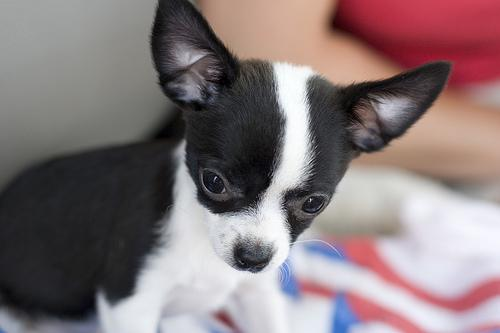

In [4]:
dogs = list(data_dir.glob('n02085620-Chihuahua/*'))
PIL.Image.open(str(dogs[0]))

**Load data using a Keras utility**

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the Load and preprocess images tutorial.

**Create a dataset**

Define some parameters for the loader:

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3

input_shape = (img_height,img_width,channels)

batch_input_shape = (batch_size, img_height, img_width, channels)

In [7]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.


2023-11-26 23:16:09.484174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 23:16:09.487682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 23:16:09.487798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# A popular split is 80%, 10% and 10% for the train, validation and test sets.

train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [9]:
class_names = ds.class_names
print(class_names)

num_classes = len(class_names)
print("num_classes : ",num_classes)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

**Visualize the data**

Here are the first nine images from the training dataset:

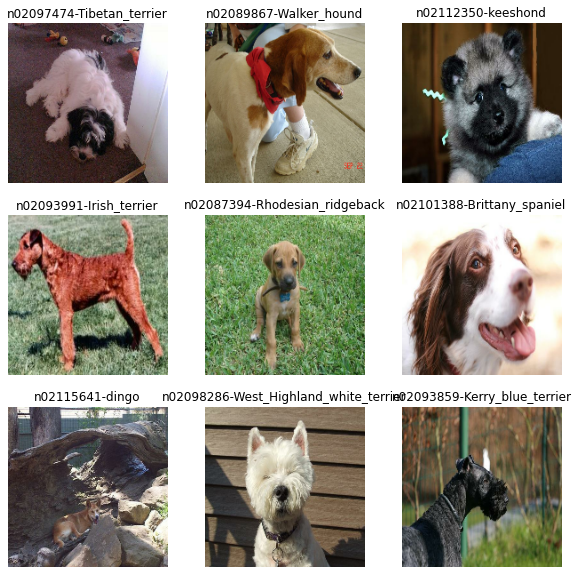

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

**Configure the dataset for performance**

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [13]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

**Note**: You previously resized images using the image_size argument of tf.keras.utils.image_dataset_from_directory. If you want to include the resizing logic in your model as well, you can use the tf.keras.layers.Resizing layer.

**Overfitting**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

**Data augmentation**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=input_shape),
    layers.RandomRotation(0.1)
    #layers.RandomZoom(0.1)
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

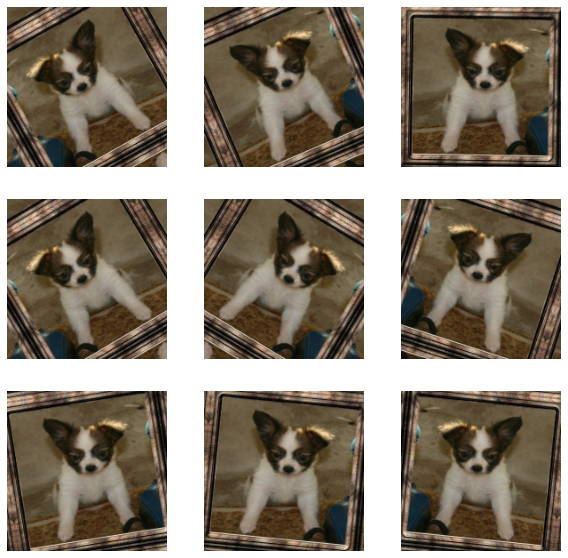

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

**Dropout**

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

4. **Building a Model**

- Build a model using Tensorflow or Pytorch
- Your model should include Conv2D, MaxPooling2D, Flatten, Dense and
Dropout.(Number of layers is up to you)
- Compile your model and print the summary of the model.
- Train your model using train and validation subsets
- Plot model’s accuracy, validation accuracy, loss and validation loss.

**Hint**: Use “Softmax” as the activation function of the last Dense Layer.

**Create the model**

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.build(input_shape = batch_input_shape)

**Train the model with the ModelCheckpoint callback and keep history**

In [18]:
# cancelled
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

**Compile the model**

For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model summary**

View all the layers of the network using the Keras Model.summary method:

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

**Train the model**

Train the model for xxx epochs with the Keras Model.fit method:

In [21]:
epochs = 100

history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs
   #callbacks=[checkpoint] cancelled
)

Epoch 1/100


/home/gurkan/.local/lib/python3.10/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-11-26 23:16:22.687345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-26 23:16:22.815181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 23:16:22.906520: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 23:16:23.559571: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2bb7dd570 initialized for platform CUDA (this does not guarantee that 

515/515 [==============================] - 16s 25ms/step - loss: 4.7390 - accuracy: 0.0158 - val_loss: 4.6005 - val_accuracy: 0.0229
Epoch 2/100
515/515 [==============================] - 9s 17ms/step - loss: 4.4851 - accuracy: 0.0306 - val_loss: 4.3522 - val_accuracy: 0.0386
Epoch 3/100
515/515 [==============================] - 9s 17ms/step - loss: 4.2862 - accuracy: 0.0477 - val_loss: 4.2072 - val_accuracy: 0.0566
Epoch 4/100
515/515 [==============================] - 9s 17ms/step - loss: 4.1733 - accuracy: 0.0633 - val_loss: 4.0670 - val_accuracy: 0.0752
Epoch 5/100
515/515 [==============================] - 9s 17ms/step - loss: 4.0794 - accuracy: 0.0745 - val_loss: 3.9998 - val_accuracy: 0.0894
Epoch 6/100
515/515 [==============================] - 9s 17ms/step - loss: 3.9998 - accuracy: 0.0878 - val_loss: 3.9051 - val_accuracy: 0.0957
Epoch 7/100
515/515 [==============================] - 9s 17ms/step - loss: 3.9151 - accuracy: 0.0944 - val_loss: 3.8396 - val_accuracy: 0.1094
Epo

515/515 [==============================] - 9s 18ms/step - loss: 2.4493 - accuracy: 0.3682 - val_loss: 2.8165 - val_accuracy: 0.3438
Epoch 58/100
515/515 [==============================] - 9s 18ms/step - loss: 2.4408 - accuracy: 0.3721 - val_loss: 2.7306 - val_accuracy: 0.3550
Epoch 59/100
515/515 [==============================] - 9s 18ms/step - loss: 2.4146 - accuracy: 0.3832 - val_loss: 2.7515 - val_accuracy: 0.3340
Epoch 60/100
515/515 [==============================] - 9s 18ms/step - loss: 2.4281 - accuracy: 0.3745 - val_loss: 2.8534 - val_accuracy: 0.3306
Epoch 61/100
515/515 [==============================] - 9s 18ms/step - loss: 2.3991 - accuracy: 0.3837 - val_loss: 2.6784 - val_accuracy: 0.3574
Epoch 62/100
515/515 [==============================] - 9s 18ms/step - loss: 2.3817 - accuracy: 0.3845 - val_loss: 2.6855 - val_accuracy: 0.3643
Epoch 63/100
515/515 [==============================] - 9s 18ms/step - loss: 2.3589 - accuracy: 0.3896 - val_loss: 2.6689 - val_accuracy: 0.355

In [22]:
# cancelled
# save model
# model.save('my_model.keras')

**Visualize training results**

After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

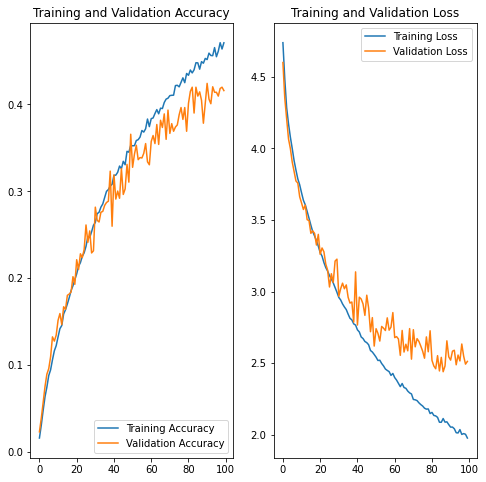

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Testing the CNN model**

Use your model to classify an image that wasn't included in the training or validation sets.

In [24]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
65/65 [==============================] - 7s 8ms/step - loss: 2.5441 - accuracy: 0.4069
Test Accuracy: 40.69%


In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


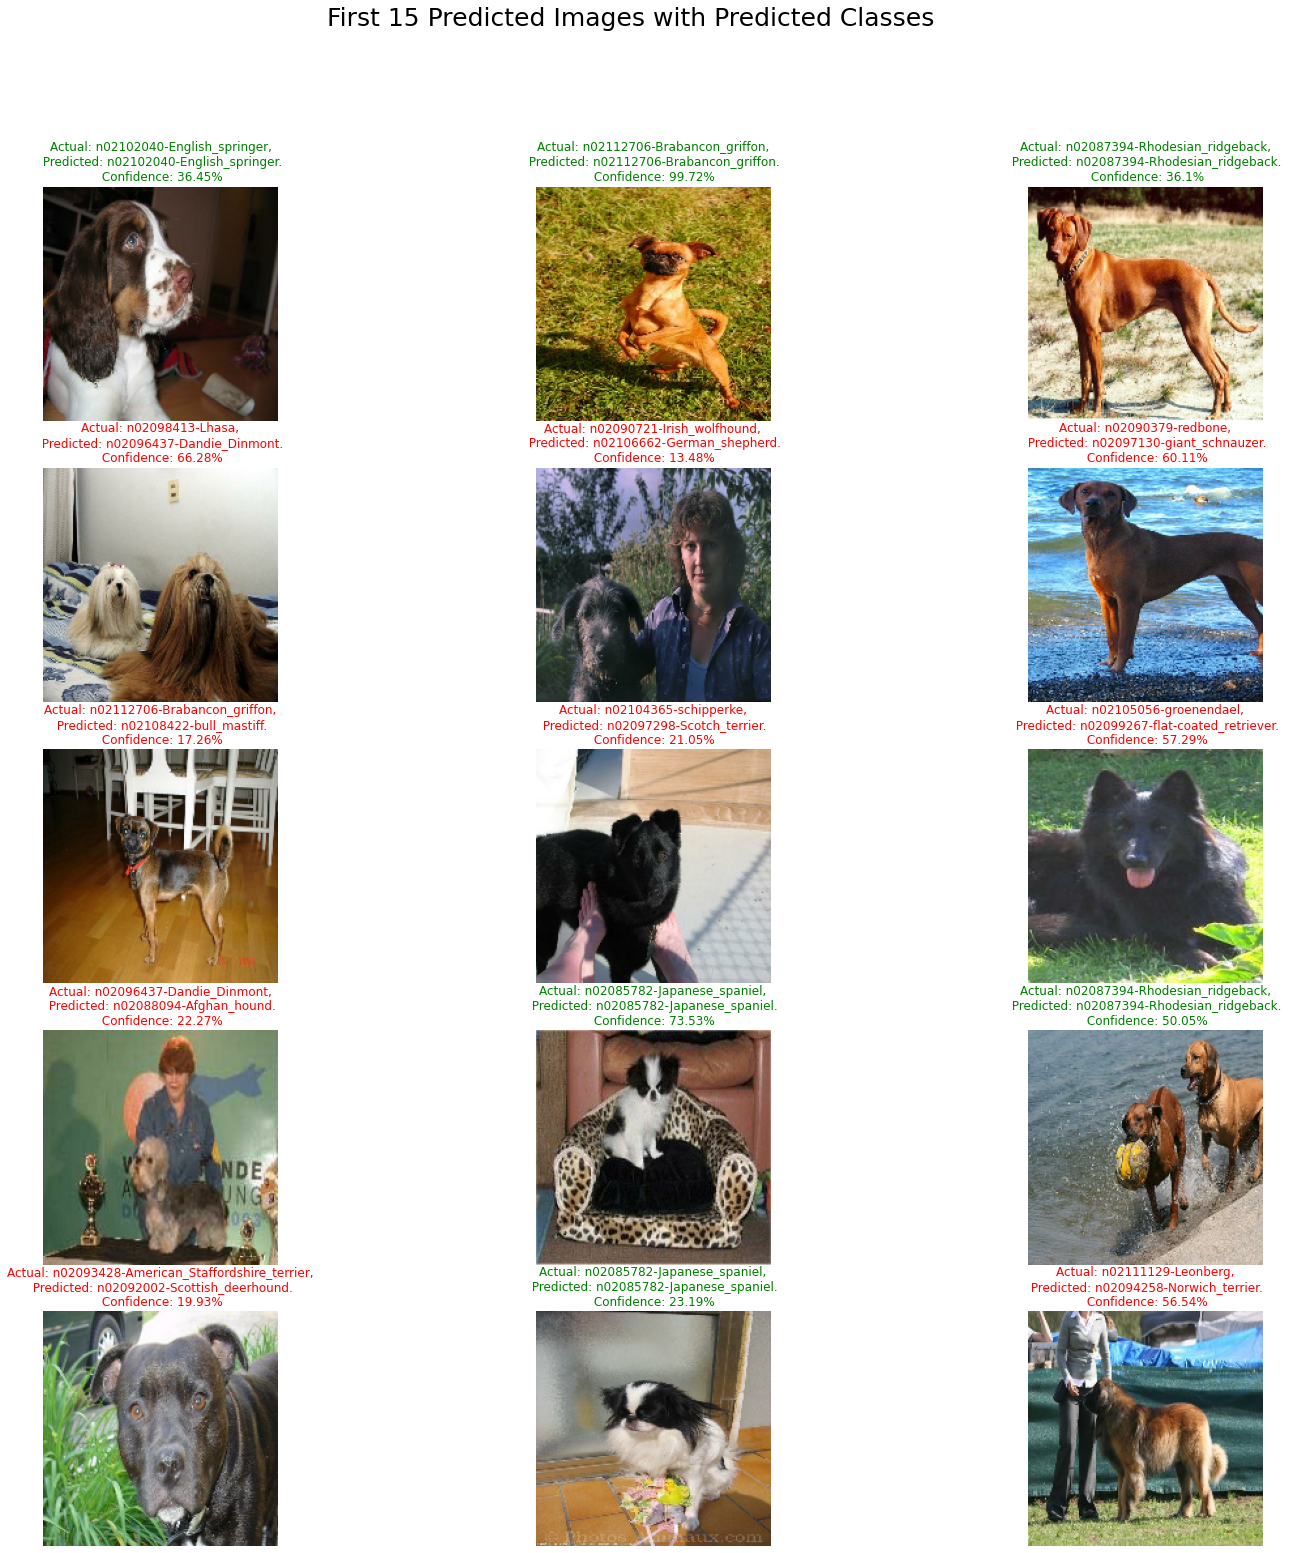

In [26]:
plt.figure(figsize=(25, 25))

plt.suptitle('First 15 Predicted Images with Predicted Classes', size=25)

for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 

        if actual_class == predicted_class:
          title_color = 'green'
        else:
          title_color = 'red'

        title = f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%"

        plt.title(title, color=title_color)

        plt.axis("off")